## Northwestern Intercampus Shuttle

After yet another frigid morning with a late shuttle arrival, my flustered wife vented via text about the unreliability of Northwestern's intercampus shuttle. Armed with a little bit of code and a matrimonial sense of duty, I attempted to determine conclusively the shuttle's reliability.

The data analyzed in this notebook was collected in August-October 2015, about 6 weeks (~30 stops per schedule stop) worth in total. We'll use heatmaps to visualize whether the shuttle is on time and by how much it deviates from its schedule, then apply a K-Means algorithm to try to guess what the scheduled time is from the data and compare it to the timetable values.

In [1]:
# Let's import everything we need and set some parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'xtick.labelsize': 14})
matplotlib.rcParams.update({'ytick.labelsize': 14})

First, let's read in the data! The data about when each shuttle stop was made is in `intercampus_data.csv`. The northbound and southbound schedules are in `evanstontochicago.csv` and `chicagotoevanston.csv`.

In [2]:
stops = pd.read_csv('intercampus_data.csv')
northsouth = pd.read_csv('evanstontochicago.csv')
southnorth = pd.read_csv('chicagotoevanston.csv')

What do we have here...

In [3]:
stops.head(5)

,Route ID,Route Name,Bus ID,Bus Name,Stop ID,Stop Name,Seconds after midnight,Time
0,48,Intercampus (I),29974,29741,294,Emerson/Maple,64653,2016-08-08 17:57:33.504574
1,48,Intercampus (I),29729,29729,282,Central L Station (westbound),64674,2016-08-08 17:57:54.206635
2,48,Intercampus (I),29727,29727,313,Chicago/Kedzie,64694,2016-08-08 17:58:14.943511
3,48,Intercampus (I),29729,29729,252,Central/Jackson (westbound),64745,2016-08-08 17:59:05.908323
4,48,Intercampus (I),29974,29741,183,Sherman/Emerson,64766,2016-08-08 17:59:26.634276


Ah, it appears we have some information about the route, the bus, the stop, and when the bus on a given route stopped at a given stop. That last piece of information appears in two formats: as a timestamp and as the number of seconds after midnight; the latter will be a little bit easier to work with because we want to overlay all of the stop times on the same 1-day timescale.

Let's quickly plot some arbitrary data over time to see what it looks like.

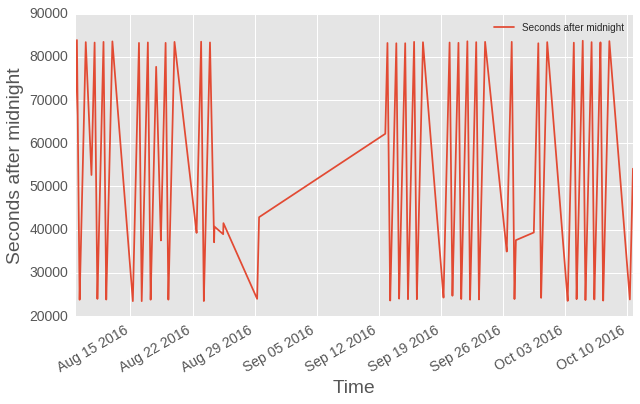

In [4]:
stops['Time'] = pd.to_datetime(stops['Time'])
stops.plot(x='Time', y='Seconds after midnight', figsize=(10, 6))
plt.ylabel('Seconds after midnight')

So we can see that there are some chunks of data missing, but it looks like we have about 5-6 weeks worth of data that should correspond to about 25-30 recorded stops per scheduled shuttle stop.

Here are all the stops on our route:

In [5]:
pd.unique(stops['Stop Name'])

array(['Emerson/Maple', 'Central L Station (westbound)', 'Chicago/Kedzie',
       'Central/Jackson (westbound)', 'Sherman/Emerson', 'Sherman/Foster',
       'Chicago/Lee', 'Ryan Field', 'Sherman/Gaffield',
       'Sheridan/Loyola (southbound)', 'Weber Arch', 'Jacobs Center',
       'Chicago/Sheridan', 'Tech Institute', 'Patten Gym', 'Chicago/Grove',
       'Central/Jackson (eastbound)', 'Central L Station (eastbound)',
       'Noyes L Station', 'Chicago/Greenleaf', 'Ridge/Civic Center',
       'Chicago/Main', 'Ridge/Reserve Apartments', 'Ward Building',
       'Sheridan/Noyes', 'Chicago/Davis', 'Sheridan/Foster',
       'Sheridan/Loyola (northbound)'], dtype=object)

Now let's look at the schedule data. 

In [6]:
northsouth.head(5)

,Ryan Field,Central/Jackson (eastbound),Central L Station (eastbound),Noyes L Station,Ridge/Civic Center,Ridge/Reserve Apartments,Emerson/Maple,Sherman/Emerson,Sherman/Foster,Sherman/Gaffield,Sheridan/Noyes,Sheridan/Foster,Chicago/Sheridan,Chicago/Grove,Chicago/Greenleaf,Chicago/Main,Sheridan/Loyola (southbound),Ward Building
0,0.274329,0.275023,0.275718,0.277106,0.278495,0.279190,0.280579,0.281968,0.282662,0.283356,0.284745,0.286134,0.287523,0.289606,0.291690,0.292384,0.299329,0.327106
1,0.284745,0.285440,0.286134,0.287523,0.288912,0.289606,0.290995,0.292384,0.293079,0.293773,0.295162,0.296551,0.297940,0.300023,0.302106,0.302801,0.309745,0.337523
2,0.295162,0.295856,0.296551,0.297940,0.299329,0.300023,0.301412,0.302801,0.303495,0.304190,0.305579,0.306968,0.308356,0.310440,0.312523,0.313218,0.320162,0.347940
3,0.315995,0.316690,0.317384,0.318773,0.320162,0.320856,0.322245,0.323634,0.324329,0.325023,0.326412,0.327801,0.329190,0.331273,0.333356,0.334051,0.340995,0.368773
4,0.347245,0.347940,0.348634,0.350023,0.351412,0.352106,0.353495,0.354884,0.355579,0.356273,0.357662,0.359051,0.360440,0.362523,0.364606,0.365301,0.372245,0.393079


The format for this data appears to be the day-fraction at which the bus stops. To use it, we'll just multiply by 24 x 60 to get units of minutes or 24 x 3600 to get units of seconds.

In [7]:
northsouth = northsouth * 24 * 60
southnorth = southnorth * 24 * 60

In [8]:
pd.unique(northsouth.columns)

array(['Ryan Field', 'Central/Jackson (eastbound)',
       'Central L Station (eastbound)', 'Noyes L Station',
       'Ridge/Civic Center', 'Ridge/Reserve Apartments', 'Emerson/Maple',
       'Sherman/Emerson', 'Sherman/Foster', 'Sherman/Gaffield',
       'Sheridan/Noyes', 'Sheridan/Foster', 'Chicago/Sheridan',
       'Chicago/Grove', 'Chicago/Greenleaf', 'Chicago/Main',
       'Sheridan/Loyola (southbound)', 'Ward Building'], dtype=object)

Note that not all of the stops are on each route! Most are northbound or southbound only. 

First, let's look at our morning route from Evanston to Chicago by collecting a list of each stop's recorded shuttle stops using the unit of seconds after midnight.

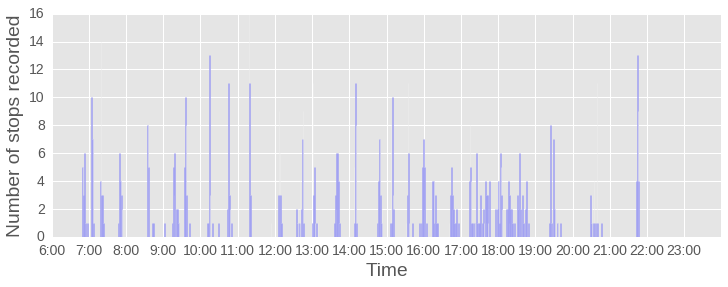

In [9]:
# Collect recorded stops in units of minutes
stop_times = {}
for stop_name in northsouth.columns:
    stop_times[stop_name] = stops[stops['Stop Name'] == stop_name]['Seconds after midnight'] / 60

# Parameters to control the window
start_hour = 6
end_hour = 24
interval_in_min = 1

# Make the bins and the histogram
interval_bins = np.arange(start_hour * 60, end_hour * 60 + 1, interval_in_min)
stop_times['Sherman/Foster'].hist(bins=interval_bins, figsize=(12,4), color='b')

# Formatting
time_labels = [ str(x) + ':00' for x in range(start_hour, end_hour)]
plt.xlim(start_hour * 60, end_hour * 60)
plt.xticks(np.arange(start_hour * 60, end_hour * 60, 60), time_labels)
plt.xlabel('Time')
plt.ylabel('Number of stops recorded')

We're looking at a plot of the number of stops recorded in 1-minute bins during the day. Already we can see a few interesting trends - large peaks should probably correspond with regularly scheduled stop times. Let's see where the shuttle stops actually are by writing a function and using it to look more closely at the data.

In [10]:
def plot_stop_histogram(stop_series, scheduled_stops, start_hour=6, end_hour=24, minutes_per_interval=1):
    '''Plots a histogram of recorded shuttle stops in time bins
        input
            stop_series - Pandas Series of recorded stop times in units of seconds after midnight
            scheduled_stops - Pandas Series of scheduled stops
            start_hour - hour to start binning
            end_hour - hour to stop binning
            minutes_per_interval - how many minutes each bin should encapsulate
        output
            None
    '''
    # Create the bins for the histogram
    interval_bins = np.arange(start_hour * 60, end_hour * 60 + 1, minutes_per_interval)
    stop_series.hist(bins=interval_bins, figsize=(12,4), color='b', alpha=1, grid=False)
    time_labels = [ str(x) + ':00' for x in range(start_hour, end_hour)]
    
    # Format the plot
    plt.xlim(start_hour * 60, end_hour * 60)
    plt.xticks(np.arange(start_hour * 60, end_hour * 60, 60), time_labels)
    plt.xlabel('Time')
    plt.ylabel('Number of stops recorded')
    
    # Add vertical lines at scheduled stop times, remembering to convert the scheduled time from day to minute
    mincts, maxcts = plt.ylim()
    plt.vlines(scheduled_stops, ymin=0, ymax=maxcts, linestyles='--', color='k', alpha=0.2)

I live at Sherman and Foster, so let's look there and zoom in on the evening rush hour.

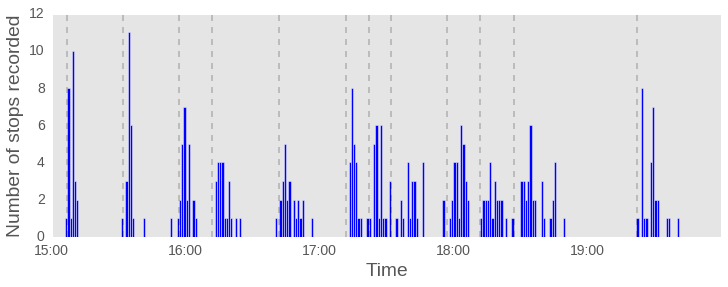

In [11]:
stop_name = 'Sherman/Foster'
plot_stop_histogram(stop_times[stop_name], northsouth[stop_name], start_hour=15, end_hour=20)

Uh oh. Looks like we've got some differences at rush hour between the scheduled stops (dashed lines) and the recorded stops (blue histogram). Let's visualize this another way using a heatmap. This will let us visualize the frequency at which stops occurred in a certain window and by choosing an appropriate color scheme will tell us whether the stop was made at the appropriate time.

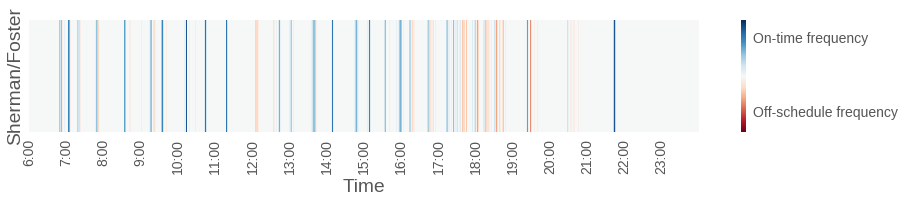

In [28]:
# Get the histogram in numerical form
stop_name = 'Sherman/Foster'
scheduled_stops = northsouth[stop_name].astype(int)
start_hour = 6
end_hour = 24
interval = 1
interval_bins = np.arange(start_hour * 60, end_hour * 60 + 1, interval)
counts, hist_bins = np.histogram(stop_times[stop_name], bins=interval_bins)

# Apply a mask using a window of time
window = 5
mask = -1 * np.ones_like(counts)
for scheduled_stop in scheduled_stops:
    index = scheduled_stop - start_hour * 60
    mask[index-5:index+5] = 1

maxcounts = max(counts)
counts = counts * mask
counts = counts.reshape(1, counts.size)
plt.figure(figsize=(15,2))
hmax = sns.heatmap(counts, cmap='RdBu', yticklabels=False, vmin=-15, vmax=15)
hmax.collections[0].colorbar.set_ticks([-10, 0, 10])
hmax.collections[0].colorbar.set_ticklabels(['Off-schedule frequency', '', 'On-time frequency'])
plt.xticks(np.arange(0, (end_hour - start_hour) * 60, 60), time_labels)
plt.xlabel('Time')
plt.ylabel('Sherman/Foster')
plt.show()

What are we looking at here? Well, whether a line is blue or red corresponds to whether or not a shuttle stop was made within a given window of time within the scheduled stop (in this case, the window length is set to 5 minutes), with blue indicating in-window arrival and red indicating out-of-window arrival. The intensity of the color corresponds to how frequently a stop was made within that one minute interval. Therefore, a dark blue line means that, over a period of 6 weeks, the shuttle frequently stopped during that one minute interval AND that interval was within 5 minutes of the scheduled stop time. On the other side, a dark red line indicates that the shuttle is stopping *reliably outside the window around the scheduled time*; in other words, the dark red lines mean the shuttle is reliably late. The lines with lighter coloring (less intensity) show that while shuttle stops were recorded during that window of time, the frequency of stops occuring in the 1-minute window is low. Lots of light lines stacked together (of either color) indicate a high variance in shuttle arrival time.

In short, dark blue lines are good and anything else is problematic. 